In [1]:
%config Completer.use_jedi = False
import sys
import warnings
warnings.filterwarnings('ignore')

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

MEMORY = 8*1024

gpus = tf.config.list_physical_devices('GPU')
try:
    tf.config.set_logical_device_configuration(gpus[0],
                                              [tf.config.LogicalDeviceConfiguration(memory_limit=MEMORY)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
except RuntimeError as e:        
    # Memory growth must be set before GPUs have been initialized
    print(e) 
    
import pathlib
import pickle
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo")
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from turing.utils import *
from turing.tf_utils import *
import turing.pinns as tu
from turing.loss_functions import *

2023-02-10 12:13:27.282305: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-10 12:13:27.475826: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-10 12:13:28.155839: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /end/home/rh2310/lib:/end/soft/Linux_2.6_64/lib::/end/home/rh2310/.conda/envs/tensorflo

1 Physical GPUs, 1 Logical GPUs


In [2]:
from local_utils import *

In [3]:
sim_name = "Koch_Meinhardt_5"
x_slice=slice(0,100,1)#slice(30,65,1)#slice(50,65,1)#
y_slice=slice(0,100,1)#slice(50,85,1)#slice(70,85,1)#
pattern = load(sim_name, x_slice, y_slice,
               data_time_start=-300,
               data_time_len=60,
               data_time_step=5)

In [4]:

def grads(pinn, ts):
    
    with tf.GradientTape(persistent=True) as tape:
        H = pinn.make_inputs(ts)
        tape.watch(H)      
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)            
            outputs = pinn.net(H)            
        
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
        grad_u = tape2.gradient(u, H)        
        u_x = grad_u[:, :, :, 0]
        u_y = grad_u[:, :, :, 1]
        u_t = grad_u[:, :, :, 2]

        grad_v = tape2.gradient(v, H)
        v_x = grad_v[:, :, :, 0]
        v_y = grad_v[:, :, :, 1]
        v_t = grad_v[:, :, :, 2]
            
    grad_u_x = tape.gradient(u_x, H)
    u_xx = grad_u_x[:, :, :, 0]
    u_yx = grad_u_x[:, :, :, 1]
    #u_tx = grad_u_x[:, :, :, 2]
    grad_u_y = tape.gradient(u_y, H)
    u_xy = grad_u_y[:, :, :, 0]
    u_yy = grad_u_y[:, :, :, 1]
    #u_ty = grad_u_y[:, :, :, 2]
    grad_v_x = tape.gradient(v_x, H)
    v_xx = grad_v_x[:, :, :, 0]
    v_yx = grad_v_x[:, :, :, 1]
    #v_tx = grad_v_x[:, :, :, 2]
    grad_v_y = tape.gradient(v_y, H)
    v_xy = grad_v_y[:, :, :, 0]
    v_yy = grad_v_y[:, :, :, 1]
    #v_ty = grad_v_y[:, :, :, 2]
    return (tf.squeeze(u),
            tf.squeeze(u_xx), tf.squeeze(u_yy), tf.squeeze(u_xy), tf.squeeze(u_yx), tf.squeeze(u_t),
            tf.squeeze(v),
            tf.squeeze(v_xx), tf.squeeze(v_yy), tf.squeeze(v_xy), tf.squeeze(v_yx), tf.squeeze(v_t))


In [5]:
def gen_series():    
    for i,t in enumerate(pattern.t_star):
        yield t, pattern.c[..., i]
        
ds = tf.data.Dataset.from_generator(gen_series,
                                    output_types=(tf.float32, tf.float32), 
                                    output_shapes=((), pattern.c.shape[:-1]))

In [6]:
pattern.t_star.shape

(12,)

In [7]:
class NN_Field3(tu.NN_Field):
    
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.scales = []
        self.biases = []

        for i, (input_n, output_n) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            rnd_init = tf.random_normal_initializer(stddev=1 /(input_n + output_n))
            W = tf.Variable(self.__make_variables__([1, self.dim_2d[0], self.dim_2d[1], input_n, output_n], rnd_init), dtype=self.dtype, name=f"W{i+1}")
            a = tf.Variable(tf.ones([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"a{i+1}")
            b = tf.Variable(tf.zeros([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"b{i+1}")
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
            
    def net(self, H):
        for W, a, b in zip(self.weights, self.scales, self.biases):            
            #print("H",H)
            #print("W",W)
            #mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])                        
            mul_outputs = [tf.reduce_sum(H*W[:, :, :, :, i], axis=-1) for i in range(W.shape[-1])]            
            mul_outputs =tf.concat([mo[:, :, :, tf.newaxis] for mo in mul_outputs], axis=-1)
            #print("mul_outputs",mul_outputs)
            #mul_outputs = tf.reduce_prod(mul_outputs, axis=4)
            #print(mul_outputs.shape)
            outputs = a * mul_outputs + b
            #print("outputs",outputs)
            #print("====================================")
            # H = tf.tanh(outputs)
            # H = tf.sigmoid(outputs)
            H = self.act(outputs)

        return outputs
    
class NN_Field4(tu.NN_Field):
#     def __init__(self, x_range, y_range, layers, dim_2d, dense_layers, dtype=tf.float32, **kwargs):        
#         super().__init__(x_range, y_range, layers, dim_2d, dtype, **kwargs)
#         self.dense_layers = dense_layers
    
    def build(self):
        """Create the state of the layers (weights)"""
        self.weights = []
        self.conv_filters = []
        self.scales = []
        self.biases = []

        for i, (input_n, output_n) in enumerate(zip(self.layers[:-1], self.layers[1:])):
            rnd_init = tf.random_normal_initializer(stddev=1 /(input_n + output_n))
            W = tf.Variable(self.__make_variables__([1, self.dim_2d[0], self.dim_2d[1], input_n, output_n], rnd_init), dtype=self.dtype, name=f"W{i+1}")
            a = tf.Variable(tf.ones([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"a{i+1}")
            b = tf.Variable(tf.zeros([1, self.dim_2d[0], self.dim_2d[1], output_n], dtype=self.dtype), dtype=self.dtype, name=f"b{i+1}")
            rnd_init = tf.random_normal_initializer(stddev=1/10)
            c = tf.Variable(self.__make_variables__([1, 3, 3, output_n], rnd_init), dtype=self.dtype, name=f"c{i+1}")
            self.weights.append(W)
            self.scales.append(a)
            self.biases.append(b)
            self.conv_filters.append(c)
                    
            
    def net(self, H):
        for W, a, b, c in zip(self.weights, self.scales, self.biases, self.conv_filters):
            #print("H",H)
            #print("W",W)
            #mul_outputs = tf.tensordot(H, W, axes=[[-1], [-1]])                        
            mul_outputs = [tf.reduce_sum(H*W[:, :, :, :, i], axis=-1) for i in range(W.shape[-1])]            
            mul_outputs =tf.concat([mo[:, :, :, tf.newaxis] for mo in mul_outputs], axis=-1)
            #
            print(mul_outputs.shape)
            conv_outputs = [tf.reduce_sum(mul_outputs[:, i:i+3, j:j+3, :]*c, axis=(1, 2)) 
                               for i in range(0, mul_outputs.shape[1]-3)
                               for j in range(0, mul_outputs.shape[2]-3)] 
            print(conv_outputs[0].shape)
            conv_outputs = tf.concat([co[:, tf.newaxis, :] for co in conv_outputs], axis=1)
            print(conv_outputs.shape)
            #print("mul_outputs",mul_outputs)
            #mul_outputs = tf.reduce_prod(mul_outputs, axis=4)
            #print(mul_outputs.shape)
            outputs = a * conv_outputs + b
            #print("outputs",outputs)
            #print("====================================")
            # H = tf.tanh(outputs)
            # H = tf.sigmoid(outputs)
            H = self.act(outputs)

        return outputs

In [52]:

x_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[0]
y_range = np.linspace(0, 1, pattern.simulation.n[0])*pattern.simulation.L[1]
x_range = x_range[x_slice]
y_range = y_range[y_slice]

optimizer=keras.optimizers.Adam(learning_rate=5e-3)#keras.optimizers.SGD(learning_rate=1e-4)#
        
pinn = NN_Field3(x_range, y_range, 
                layers=[3, 6, 6, 2], 
                dim_2d=(pattern.block_x, pattern.block_x), 
                dtype=tf.float32)
norm_l2 = L2()

@tf.function
def train_step(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = pinn.make_inputs(elements[0])
        tape.watch(H)
        trainables = pinn.trainable_variables
        outputs = pinn.net(H)   
        #print(outputs.shape)
        #u = tf.squeeze(outputs[:, :, :, 0])
        #v = tf.squeeze(outputs[:, :, :, 1])
        u = outputs[:, :, :, 0]
        v = outputs[:, :, :, 1]
        
        #u_diff = u - tf.squeeze(elements[1][:, 0, :, :])
        #v_diff = v - tf.squeeze(elements[1][:, 1, :, :])
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)
        
        l2 =  l2_u_obs + 100*l2_v_obs
       
    grads = tape.gradient(l2, trainables)
    optimizer.apply_gradients(zip(grads, trainables))

    return ( l2_u_obs , l2_v_obs)




In [53]:
[ w.shape for w in pinn.weights]

[TensorShape([1, 100, 100, 3, 6]),
 TensorShape([1, 100, 100, 6, 6]),
 TensorShape([1, 100, 100, 6, 2])]

In [54]:
batch_size = 6
def print_callback(printer, losses, epoch):
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses[:4])}"
            #f" u: {losses[0]}, v: {losses[1]},\n"
            f"u: {losses[0]}, v: {losses[1]},\n")
     

    
    
losses = tu.train(epochs=15000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step,
                  train_step_returns_num = 2,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback,
                  epoch_callback=None)



Start of epoch 0
at epoch 0
 total loss: 4652478.9765625u: 195265.2265625, v: 4457213.75,

Time taken: 3.19s

Start of epoch 100
at epoch 100
 total loss: 72368.65740680695u: 24.7902193069458, v: 72343.8671875,

Time taken: 2.95s

Start of epoch 200
at epoch 200
 total loss: 11406.454887390137u: 15.887504577636719, v: 11390.5673828125,

Time taken: 2.98s

Start of epoch 300
at epoch 300
 total loss: 8926.481155395508u: 14.892532348632812, v: 8911.588623046875,

Time taken: 3.09s

Start of epoch 400
at epoch 400
 total loss: 8400.860433101654u: 13.611409664154053, v: 8387.2490234375,

Time taken: 3.07s

Start of epoch 500
at epoch 500
 total loss: 8072.394771099091u: 12.316646099090576, v: 8060.078125,

Time taken: 3.06s

Start of epoch 600
at epoch 600
 total loss: 7704.20752620697u: 11.041022300720215, v: 7693.16650390625,

Time taken: 3.07s

Start of epoch 700
at epoch 700
 total loss: 7463.784381389618u: 9.92915678024292, v: 7453.855224609375,

Time taken: 2.99s

Start of epoch 800


Start of epoch 6500
at epoch 6500
 total loss: 323.3924405872822u: 0.7415311634540558, v: 322.6509094238281,

Time taken: 3.08s

Start of epoch 6600
at epoch 6600
 total loss: 247.04752638936043u: 0.8062391579151154, v: 246.2412872314453,

Time taken: 3.14s

Start of epoch 6700
at epoch 6700
 total loss: 190.09845738112926u: 0.5044327229261398, v: 189.59402465820312,

Time taken: 3.08s

Start of epoch 6800
at epoch 6800
 total loss: 188.87384980916977u: 0.7147082686424255, v: 188.15914154052734,

Time taken: 3.13s

Start of epoch 6900
at epoch 6900
 total loss: 201.34702557325363u: 0.5437418818473816, v: 200.80328369140625,

Time taken: 3.05s

Start of epoch 7000
at epoch 7000
 total loss: 188.46807312965393u: 0.5569403171539307, v: 187.9111328125,

Time taken: 3.03s

Start of epoch 7100
at epoch 7100
 total loss: 210.97586581110954u: 0.7433523833751678, v: 210.23251342773438,

Time taken: 3.08s

Start of epoch 7200
at epoch 7200
 total loss: 204.7748715877533u: 0.7446134090423584, v:


Start of epoch 12800
at epoch 12800
 total loss: 155.86664459109306u: 0.16850921511650085, v: 155.69813537597656,

Time taken: 3.05s

Start of epoch 12900
at epoch 12900
 total loss: 161.66071444004774u: 0.18319063633680344, v: 161.47752380371094,

Time taken: 3.01s

Start of epoch 13000
at epoch 13000
 total loss: 160.9919278472662u: 0.1902463287115097, v: 160.8016815185547,

Time taken: 3.11s

Start of epoch 13100
at epoch 13100
 total loss: 185.15742069482803u: 0.17722660303115845, v: 184.98019409179688,

Time taken: 3.08s

Start of epoch 13200
at epoch 13200
 total loss: 147.9775308072567u: 0.17987379431724548, v: 147.79765701293945,

Time taken: 3.06s

Start of epoch 13300
at epoch 13300
 total loss: 258.9262799471617u: 0.1910199373960495, v: 258.7352600097656,

Time taken: 3.06s

Start of epoch 13400
at epoch 13400
 total loss: 157.43143241107464u: 0.18381278216838837, v: 157.24761962890625,

Time taken: 3.03s

Start of epoch 13500
at epoch 13500
 total loss: 158.15165019780397u

In [484]:
pinn.save(".", "saved_models/pinn_2D_Koch_Meinhardt_5_test")

In [10]:
pattern.params

{'D_u': 0.02,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 0.4,
 'mu_u': 1.0,
 'sigma_u': 0.1,
 'rho_v': 3.0,
 'sigma_v': 1.0}

In [199]:
pinn.make_inputs( pattern.t_star[-1:].astype(np.float32)).shape

TensorShape([1, 100, 100, 3])

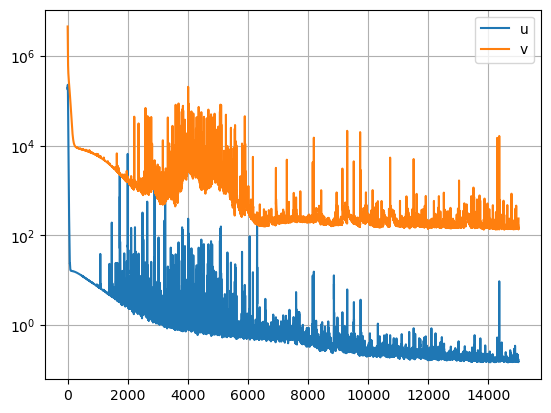

In [51]:
plt.plot(losses[0:, 0], label='u')
plt.plot(losses[0:, 1], label='v')
#plt.plot(losses[:, 2], label='res u')
#plt.plot(losses[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [39]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn, pattern.t_star[-1:].astype(np.float32))

In [40]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    #return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
    return np.sqrt(np.mean(((arr1-arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.00024920452
v:  0.020426778
u_xx:  0.0011601133
v_xx:  0.0041390583
u_yy:  0.0017917624
v_yy:  0.006096198
u_t:  0.00025543585
v_t:  0.006812824


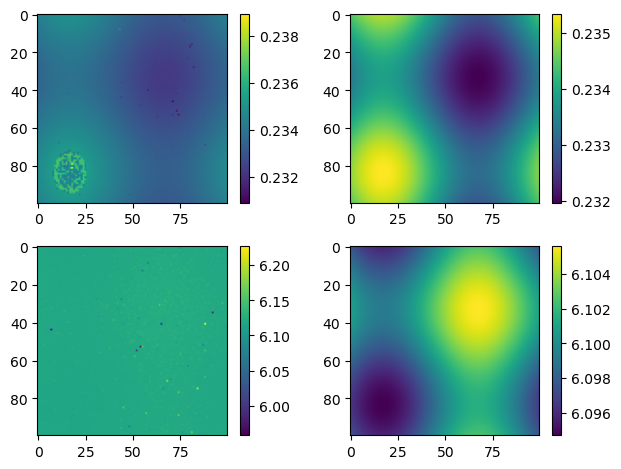

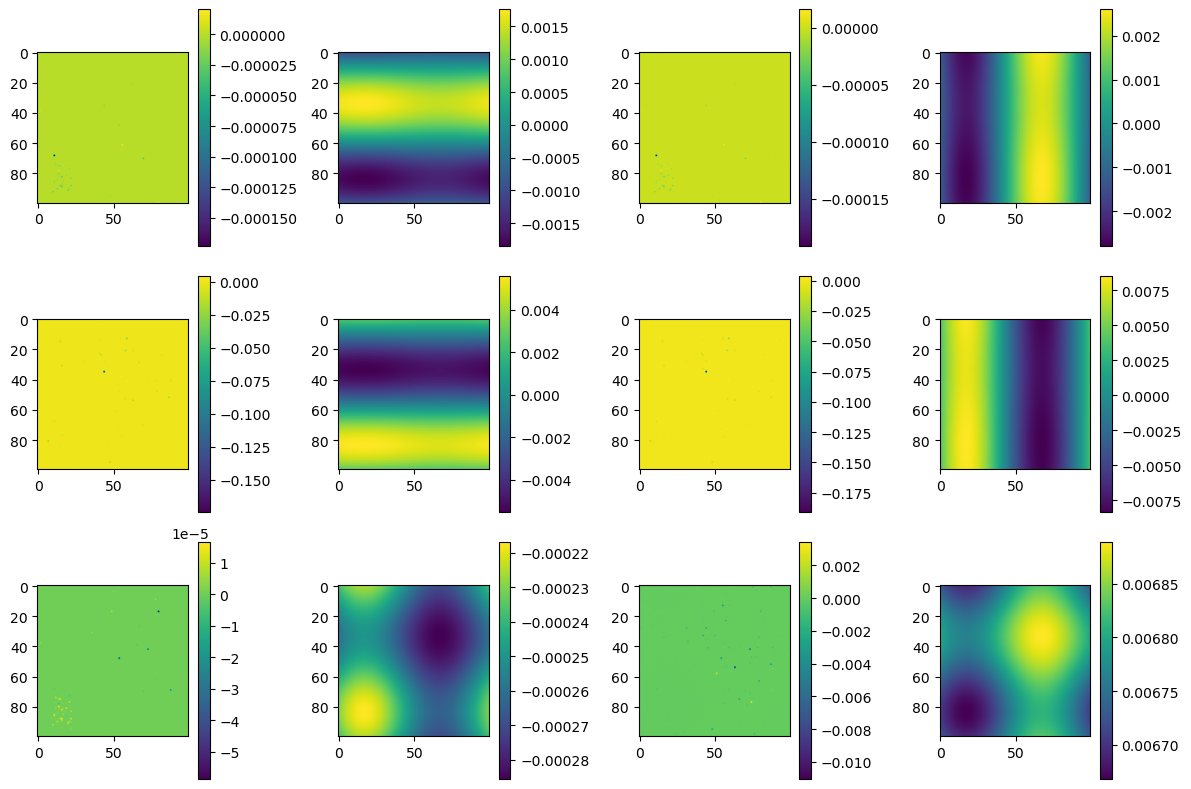

In [41]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(223)
plt.imshow(v)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [480]:
u2 = u.numpy().copy()
v2 = v.numpy().copy()

In [481]:
u2[u2 < 0.232] = 0.232
u2[u2 > 0.235] = 0.235

v2[v2 < 6.116] = 6.116
v2[v2 > 6.124] = 6.124

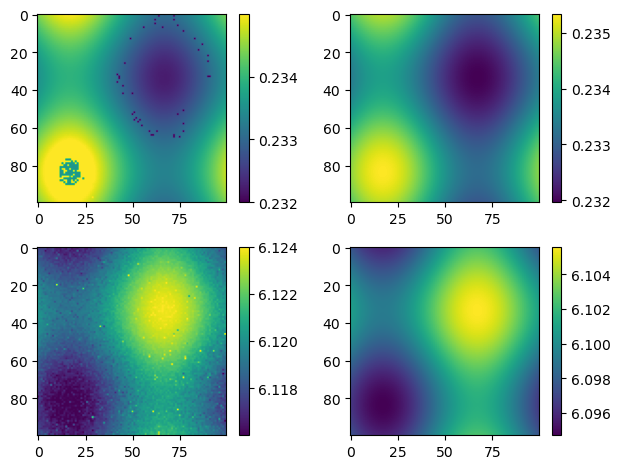

In [482]:
plt.subplot(221)
plt.imshow(u2)
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(223)
plt.imshow(v2)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.tight_layout()
plt.show()

In [495]:
optimizer2=keras.optimizers.Adam(learning_rate=5e-3).from_config(optimizer.get_config())#keras.optimizers.SGD(learning_rate=1e-4)#
#optimizer2.build(optimizer.variables())


init_per = 2.0
D_u = tf.constant(pattern.params["D_u"], pinn.dtype, name="D_u")#tf.Variable(pattern.params["D_u"]*init_per, pinn.dtype)
D_v = tf.constant(pattern.params["D_v"], pinn.dtype, name="D_v")#tf.Variable(pattern.params["D_v"]*init_per, pinn.dtype)
def clip_by_value_zero_lb(z):
    return tf.clip_by_value(z, 0, 1e10,)

sigma_u = tf.Variable(pattern.params["sigma_u"]*init_per,
                      pinn.dtype,
                      name="sigma_u",
                      constraint=clip_by_value_zero_lb)


sigma_v = tf.Variable(pattern.params["sigma_v"]*init_per,
                      pinn.dtype,
                      name="sigma_v",
                      constraint=clip_by_value_zero_lb)

mu_u = tf.Variable(pattern.params["mu_u"]*init_per,
                   pinn.dtype,
                   name="mu_u",
                   constraint=clip_by_value_zero_lb)

rho_u = tf.Variable(pattern.params["rho_u"]*init_per,
                    pinn.dtype,
                    name="rho_u",
                    constraint=clip_by_value_zero_lb)

rho_v = tf.Variable(pattern.params["rho_v"]*init_per,
                    pinn.dtype,
                    name="rho_v",
                    constraint=clip_by_value_zero_lb)

kappa_u = tf.Variable(pattern.params["kappa_u"]*init_per,
                      pinn.dtype,
                      name="kappa_u",
                      constraint=clip_by_value_zero_lb)


params_tf = (sigma_u, sigma_v, mu_u, rho_u, rho_v, kappa_u,)

# lambda_1 =tf.Variable(1.0, dtype=pinn.dtype)
# lambda_2 =tf.Variable(1.0, dtype=pinn.dtype)
# lambda_3 =tf.Variable(1.0, dtype=pinn.dtype)
# lambda_4 =tf.Variable(1.0, dtype=pinn.dtype)

pinn_copy = pinn.copy()

@tf.function
def train_step_inverse(elements):
    with tf.GradientTape(persistent=True) as tape: 
        H = pinn_copy.make_inputs(elements[0])
        tape.watch(H)
        trainables = pinn_copy.trainable_variables
        
        with tf.GradientTape(persistent=True) as tape2:             
            tape2.watch(H)
            
            outputs = pinn_copy.net(H)            
            u = tf.squeeze(outputs[:, :, :, 0])
            v = tf.squeeze(outputs[:, :, :, 1])
            
            grad_u = tape2.gradient(u, H)
            u_x = grad_u[:, :, :, 0]
            u_y = grad_u[:, :, :, 1]
            u_t = grad_u[:, :, :, 2]
            
            grad_v = tape2.gradient(v, H)
            v_x = grad_v[:, :, :, 0]
            v_y = grad_v[:, :, :, 1]
            v_t = grad_v[:, :, :, 2]
                    
        grad_u_x = tape.gradient(u_x, H)
        u_xx = grad_u_x[:, :, :, 0]
        #u_yx = grad_u_x[:, :, :, 1]
        #u_tx = grad_u_x[:, :, :, 2]
        grad_u_y = tape.gradient(u_y, H)
        #u_xy = grad_u_y[:, :, :, 0]
        u_yy = grad_u_y[:, :, :, 1]
        #u_ty = grad_u_y[:, :, :, 2]
        grad_v_x = tape.gradient(v_x, H)
        v_xx = grad_v_x[:, :, :, 0]
        #v_yx = grad_v_x[:, :, :, 1]
        #v_tx = grad_v_x[:, :, :, 2]
        grad_v_y = tape.gradient(v_y, H)
        #v_xy = grad_v_y[:, :, :, 0]
        v_yy = grad_v_y[:, :, :, 1]
        #v_ty = grad_v_y[:, :, :, 2]
                             
        f = u * u * v / (1.0 + kappa_u * u * u)
        f_u = D_u * (u_xx + u_yy) + rho_u * f - mu_u * u + sigma_u - u_t
        f_v = D_v * (v_xx + v_yy) - rho_v * f + sigma_v - v_t
        l2_res_u = tf.reduce_sum(f_u**2)
        l2_res_v = tf.reduce_sum(f_v**2)
        
        u_diff = u - elements[1][:, 0, :, :]
        v_diff = v - elements[1][:, 1, :, :]
        l2_u_obs = tf.reduce_sum(u_diff**2)
        l2_v_obs = tf.reduce_sum(v_diff**2)

        #u_xyyx_diff = u_xy - u_yx
        #v_xyyx_diff = v_xy - v_yx
        #l2_res_u_xyyx = tf.reduce_sum(u_xyyx_diff**2)
        #l2_res_v_xyyx = tf.reduce_sum(v_xyyx_diff**2)

                
        #l2 = lambda_1*l2_u_obs + lambda_2*l2_v_obs + lambda_3*l2_res_u + lambda_4*l2_res_v# + l2_res_u_xyyx + l2_res_v_xyyx
        l2 = l2_u_obs + l2_v_obs + l2_res_u + l2_res_v# + l2_res_u_xyyx + l2_res_v_xyyx
       
    grads = tape.gradient(l2, trainables + params_tf)
    optimizer2.apply_gradients(zip(grads, trainables + params_tf))
    ##############################################
#     g1 = tf.reduce_sum([tf.reduce_sum(item**2) for item in tf.gradients(l2_u_obs, trainables)])
#     g2 = tf.reduce_sum([tf.reduce_sum(item**2) for item in tf.gradients(l2_v_obs, trainables)])
#     g3 = tf.reduce_sum([tf.reduce_sum(item**2) for item in tf.gradients(l2_res_u, trainables)])
#     g4 = tf.reduce_sum([tf.reduce_sum(item**2) for item in tf.gradients(l2_res_v, trainables)])
#     penalty_power = 2
#     W1 = g1**penalty_power/tf.sqrt(l2_u_obs)
#     W2 = g2**penalty_power/tf.sqrt(l2_v_obs)
#     W3 = g3**penalty_power/tf.sqrt(l2_res_u)
#     W4 = g4**penalty_power/tf.sqrt(l2_res_v)

#     w_total = W1 + W2 + W3 + W4
#     alpha=.2
#     lambda_1.assign(alpha*lambda_1 + (1.0-alpha)*4.0*W1/w_total)
#     lambda_2.assign(alpha*lambda_2 + (1.0-alpha)*4.0*W2/w_total)
#     lambda_3.assign(alpha*lambda_3 + (1.0-alpha)*4.0*W3/w_total)
#     lambda_4.assign(alpha*lambda_4 + (1.0-alpha)*4.0*W4/w_total)
    
    ###############################################
    return (l2_u_obs, l2_v_obs, l2_res_u, l2_res_v)#, lambda_1, lambda_2, lambda_3, lambda_4, w_total)


In [496]:
batch_size = 1
def print_callback2(printer, losses, epoch):    
    printer(f"at epoch {epoch:d}\n"
            f" total loss: {np.sum(losses[:3])}"
            f" u: {losses[0]}, v: {losses[1]},\n"
            f" Res u: {losses[2]}, Res v: {losses[3]} \n"            
            #f" lambda 1: {losses[4]}, lambda 2: {losses[5]} \n"
            #f" lambda 3: {losses[6]}, lambda 4: {losses[7]} \n"
            #f"W {losses[8]}"
           )
    printer(#f"D_u: {D_u.numpy()}, D_v: {D_v.numpy()} \n"
             f"rho_u: {rho_u.numpy()}, rho_v: {rho_v.numpy()} \n"
             f"sigma_u: {sigma_u.numpy()}, sigma_v: {sigma_v.numpy()} \n"
             f"kappa_u: {kappa_u.numpy()}, mu_u: {mu_u.numpy()} \n")            
        
losses2 = tu.train(epochs=5000+1,
                  batch_size=batch_size,
                  dataset = ds ,
                  train_step = train_step_inverse,
                  train_step_returns_num = 4,
                  print_interval=100,
                  loss_sample_interval = 1,
                  stop_threshold=1e-10,
                  print_callback = print_callback2,
                  epoch_callback=None)


Start of epoch 0
at epoch 0
 total loss: 150.21793783735484 u: 0.7224552100524306, v: 148.55334347486496,
 Res u: 0.9421391524374485, Res v: 158.86449813842773 

rho_u: 0.8004921674728394, rho_v: 5.995529651641846 
sigma_u: 0.20071424543857574, sigma_v: 1.9971193075180054 
kappa_u: 0.013001052662730217, mu_u: 1.999424695968628 

Time taken: 29.79s

Start of epoch 100
at epoch 100
 total loss: 68.82790410182497 u: 0.15817411546595395, v: 68.65322403609753,
 Res u: 0.016505950261489488, Res v: 1.7943617403507233 

rho_u: 0.7967441082000732, rho_v: 5.984733581542969 
sigma_u: 0.2013023942708969, sigma_v: 1.9911482334136963 
kappa_u: 0.040291815996170044, mu_u: 2.0006651878356934 

Time taken: 68.50s

Start of epoch 200
at epoch 200
 total loss: 68.7837410239008 u: 0.1525238282047212, v: 68.61201384663582,
 Res u: 0.019203349060262553, Res v: 2.156303122639656 

rho_u: 0.7918631434440613, rho_v: 5.97206974029541 
sigma_u: 0.20351997017860413, sigma_v: 1.98334801197052 
kappa_u: 0.07237578


Start of epoch 2400
at epoch 2400
 total loss: 68.52874831412919 u: 0.15451186941936612, v: 68.35126173496246,
 Res u: 0.022974709747359157, Res v: 1.9408861324191093 

rho_u: 0.7170654535293579, rho_v: 5.719020366668701 
sigma_u: 0.23974281549453735, sigma_v: 1.8356698751449585 
kappa_u: 0.71163010597229, mu_u: 2.0121402740478516 

Time taken: 69.16s

Start of epoch 2500
at epoch 2500
 total loss: 68.52119940088596 u: 0.15379891963675618, v: 68.34433034062386,
 Res u: 0.023070140625350177, Res v: 1.7285932376980782 

rho_u: 0.7162225246429443, rho_v: 5.706731796264648 
sigma_u: 0.2403019368648529, sigma_v: 1.828794240951538 
kappa_u: 0.7425074577331543, mu_u: 2.0118038654327393 

Time taken: 69.34s

Start of epoch 2600
at epoch 2600
 total loss: 68.50268993462669 u: 0.1545247845351696, v: 68.32486614584923,
 Res u: 0.02329900424228981, Res v: 1.9125089421868324 

rho_u: 0.7155319452285767, rho_v: 5.694420337677002 
sigma_u: 0.24079830944538116, sigma_v: 1.8218748569488525 
kappa_u: 0


Start of epoch 4800
at epoch 4800
 total loss: 68.37242323264945 u: 0.1613624133169651, v: 68.18747708201408,
 Res u: 0.02358373731840402, Res v: 2.5860161408782005 

rho_u: 0.7239344120025635, rho_v: 5.392879009246826 
sigma_u: 0.24282406270503998, sigma_v: 1.6599185466766357 
kappa_u: 1.526993989944458, mu_u: 1.994457721710205 

Time taken: 70.12s

Start of epoch 4900
at epoch 4900
 total loss: 68.36938030365855 u: 0.16143739875406027, v: 68.18409217894077,
 Res u: 0.02385072596371174, Res v: 2.575900971889496 

rho_u: 0.7249910235404968, rho_v: 5.378027439117432 
sigma_u: 0.24266566336154938, sigma_v: 1.6523343324661255 
kappa_u: 1.5637556314468384, mu_u: 1.993430733680725 

Time taken: 69.50s

Start of epoch 5000
at epoch 5000
 total loss: 68.34834315284388 u: 0.15938380267471075, v: 68.16503475606441,
 Res u: 0.02392459410475567, Res v: 2.1153158769011497 

rho_u: 0.7261008620262146, rho_v: 5.362871170043945 
sigma_u: 0.24250145256519318, sigma_v: 1.6446161270141602 
kappa_u: 1.6

In [ ]:
'rho_u': 0.4,  'rho_v': 3.0,
'sigma_u': 0.1, 'sigma_v': 1.0,
'kappa_u': 0.0, 'mu_u': 1.0,

In [486]:
pattern.params

{'D_u': 0.02,
 'D_v': 1.0,
 'kappa_u': 0.0,
 'rho_u': 0.4,
 'mu_u': 1.0,
 'sigma_u': 0.1,
 'rho_v': 3.0,
 'sigma_v': 1.0}

In [497]:
def Euclidian_L(vec1, vec2):
    def L(v):
        return np.sqrt(np.sum(v**2))
    v2 = vec2.copy()
    v2[v2==0] = 1
    return L((vec1-vec2)/v2)

u_vec_ac = np.array([pattern.params["rho_u"], pattern.params["mu_u"],
                     pattern.params["sigma_u"], pattern.params["kappa_u"]])

u_vec    = np.array([rho_u.numpy(), mu_u.numpy(), sigma_u.numpy(), kappa_u.numpy()])

v_vec_ac = np.array([pattern.params["rho_v"], 
                     pattern.params["sigma_v"], pattern.params["kappa_u"]])

v_vec    = np.array([rho_v.numpy(), sigma_v.numpy(), kappa_u.numpy()])

print(f"U params. estimates: {Euclidian_L(u_vec, u_vec_ac)}")
print(f"V params. estimates: {Euclidian_L(v_vec, v_vec_ac)}")

U params. estimates: 2.4988049309919647
V params. estimates: 1.8973124739141687


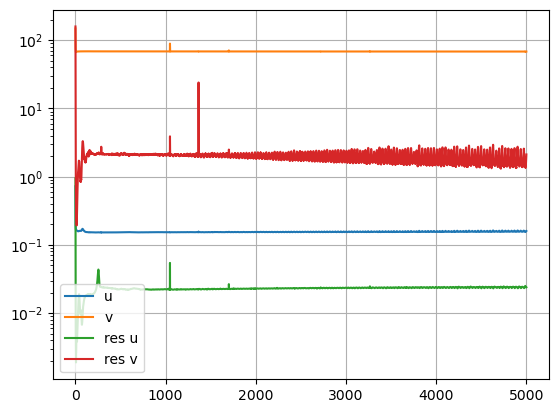

In [498]:
plt.plot(losses2[0:, 0], label='u')
plt.plot(losses2[0:, 1], label='v')
plt.plot(losses2[:, 2], label='res u')
plt.plot(losses2[:, 3], label='res v')
plt.yscale('log')
plt.grid(); plt.legend(); plt.show()

In [499]:
(u, u_xx, u_yy, u_xy, u_yx, u_t, 
 v, v_xx, v_yy, v_xy, v_yx, v_t) = grads(pinn_copy, pattern.t_star[-1:].astype(np.float32))

In [500]:
def RMSE(arr1, arr2):
    #return np.sqrt(np.mean(((arr1-arr2)/np.max(arr2))**2))
    #return np.sqrt(np.mean(((arr1-arr2)/(arr2+1e-20))**2))
    return np.sqrt(np.mean(((arr1-arr2))**2))
                          
print("u: ", RMSE(u, pattern.c[0,:, : , -1]))
print("v: ", RMSE(v, pattern.c[1,:, : , -1]))
print("u_xx: ", RMSE(u_xx, pattern.c_xx[0,:, : , -1]))
print("v_xx: ", RMSE(v_xx, pattern.c_xx[1,:, : , -1]))
print("u_yy: ", RMSE(u_yy, pattern.c_yy[0,:, : , -1]))
print("v_yy: ", RMSE(v_yy, pattern.c_yy[1,:, : , -1]))
print("u_t: ", RMSE(u_t, pattern.c_t[0,:, : , -1]))
print("v_t: ", RMSE(v_t, pattern.c_t[1,:, : , -1]))

u:  0.00076683046
v:  0.019577
u_xx:  0.0011609821
v_xx:  0.0036964498
u_yy:  0.0017925338
v_yy:  0.005743046
u_t:  0.00025481227
v_t:  0.0068198405


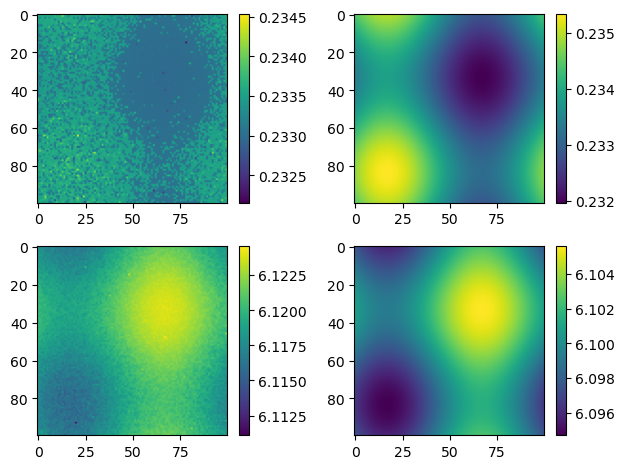

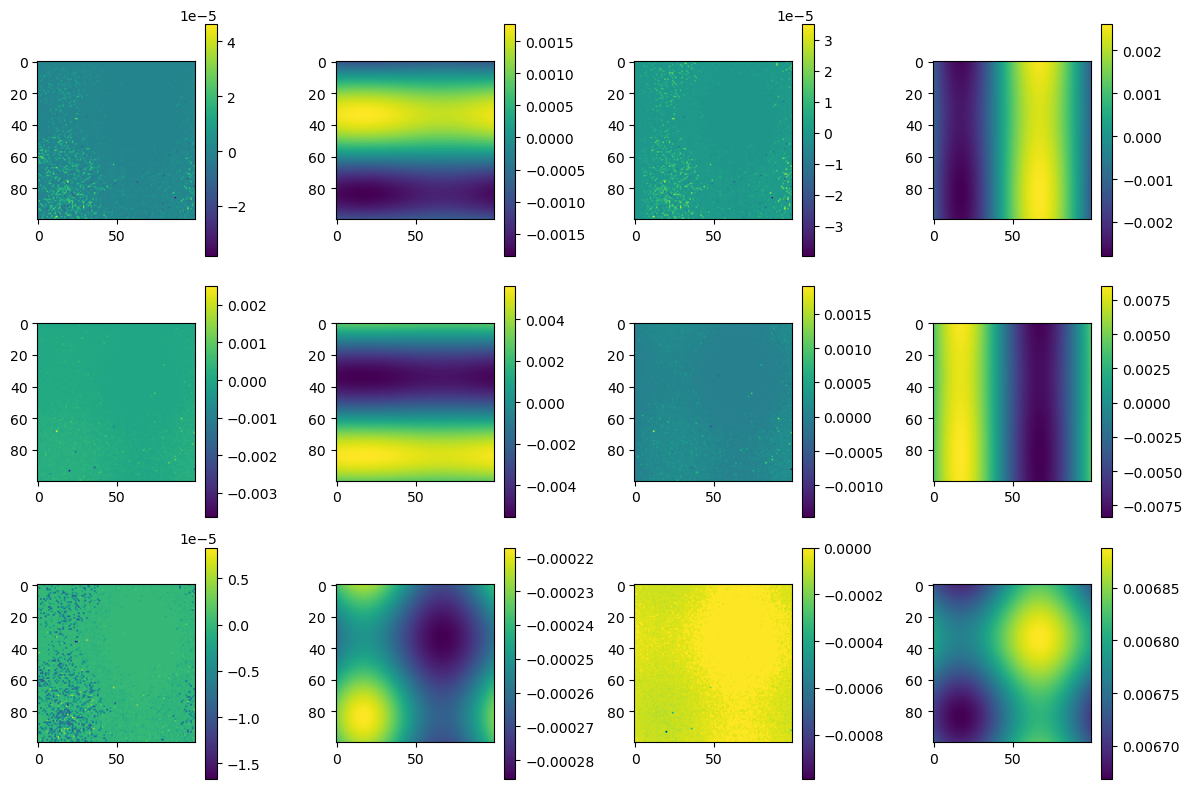

In [501]:
plt.subplot(221)
plt.imshow(u)
plt.colorbar()
plt.subplot(222)
plt.imshow(pattern.c[0,:,:,-1])
plt.colorbar()
plt.subplot(223)
plt.imshow(v)
plt.colorbar()
plt.subplot(224)
plt.imshow(pattern.c[1,:,:,-1])
plt.colorbar()
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 8))
plt.subplot(341)
plt.imshow(u_xx)
plt.colorbar()
plt.subplot(342)
plt.imshow(pattern.c_xx[0,:, : , -1])
plt.colorbar()
plt.subplot(343)
plt.imshow(u_yy)
plt.colorbar()
plt.subplot(344)
plt.imshow(pattern.c_yy[0,:, : , -1])
plt.colorbar()
plt.subplot(345)
plt.imshow(v_xx)
plt.colorbar()
plt.subplot(346)
plt.imshow(pattern.c_xx[1,:, : , -1])
plt.colorbar()
plt.subplot(347)
plt.imshow(v_yy)
plt.colorbar()
plt.subplot(3,4,8)
plt.imshow(pattern.c_yy[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.subplot(3,4,9)
plt.imshow(u_t)
plt.colorbar()
plt.subplot(3,4,10)
plt.imshow(pattern.c_t[0,:, : , -1])
plt.colorbar()
plt.subplot(3,4,11)
plt.imshow(v_t)
plt.colorbar()
plt.subplot(3,4,12)
plt.imshow(pattern.c_t[1,:, : , -1])
plt.colorbar()
plt.tight_layout()
plt.show()